# Machine Learning Algorithms
## Nearest Neighbors 
## Namrata Deshpande
### April 07, 2017


In this project we will implement basic Nearest Neighbors algorithms along with KNN and Cross Validation in Python from scratch.We will test the algorithm on Boston Housing Prices Dataset present in Python.

In [1]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn
from sklearn.cross_validation import train_test_split

C:\Program Files\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---

## Data Load and Explore

We will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing). 


In [2]:
#loading boston data
from sklearn.datasets import load_boston
bdata = load_boston()

### 1.1 Shape of data:

In [4]:
#keys in bdata
print (bdata.keys())
#features/variables in boston data
print (bdata.feature_names)
#number of rows and columns in data
print (bdata.data.shape)
#shape of median house rates data
print (bdata.target.shape)
#description of the dataset
print (bdata.DESCR)

dict_keys(['feature_names', 'DESCR', 'target', 'data'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506, 13)
(506,)
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD 



### 1.2: Distribution of housing prices

We will create a histogram to explore the distribution of dependent variable i.e. the housing prices.


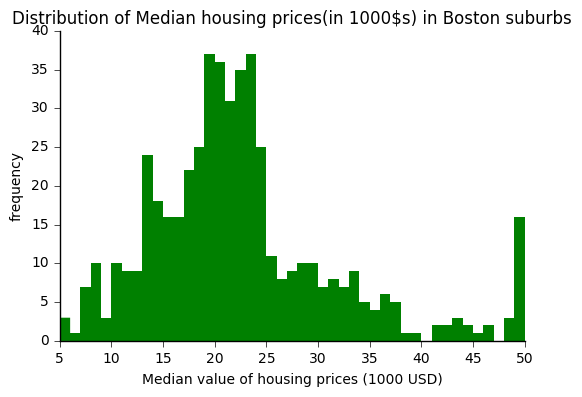

In [5]:
%matplotlib inline  
import matplotlib.pyplot as plt 
#matplotlib.style.use('ggplot')

fig = plt.figure()
ax = fig.add_subplot(111)
#histogram with binwidth 1000$ and color green with no border color
plt.hist(bdata.target ,bins = np.arange(min(bdata.target), max(bdata.target)+1,1), facecolor='g', edgecolor = "none")
#removing top and right ticks
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
#setting labels for axes and title of graph
plt.xlabel('Median value of housing prices (1000 USD)')
plt.ylabel('frequency')
plt.title('Distribution of Median housing prices(in 1000$s) in Boston suburbs')
ax.tick_params(axis='both', direction='out') 
# remove unneeded ticks 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

plt.show()


### 1.3: Scatter plot of housing prices and crime rate


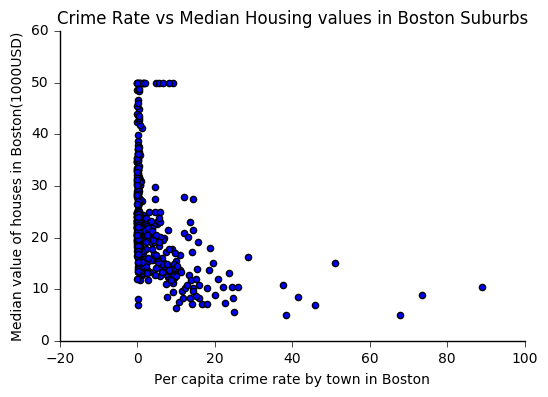

In [6]:
# converting boston data to dataframe and setting column names
boston_df = pd.DataFrame(bdata.data)
boston_df.columns=bdata.feature_names
#adding median values data to the dataframe
boston_df['MEDV']=bdata.target
#generating scatter plot between crime rate and median house rates
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x=boston_df['CRIM'], y=boston_df['MEDV'])
#removing top and right ticks
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='both', direction='out')
# remove unneeded ticks 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
#setting axes labels and plot title
plt.xlabel('Per capita crime rate by town in Boston')
plt.ylabel('Median value of houses in Boston(1000USD)')
plt.title('Crime Rate vs Median Housing values in Boston Suburbs')
plt.show()


### 1.4 Other realtionships

We will create a box plot for meadian housing prices to see its distribution with respect to the lower status people and Number of rooms.

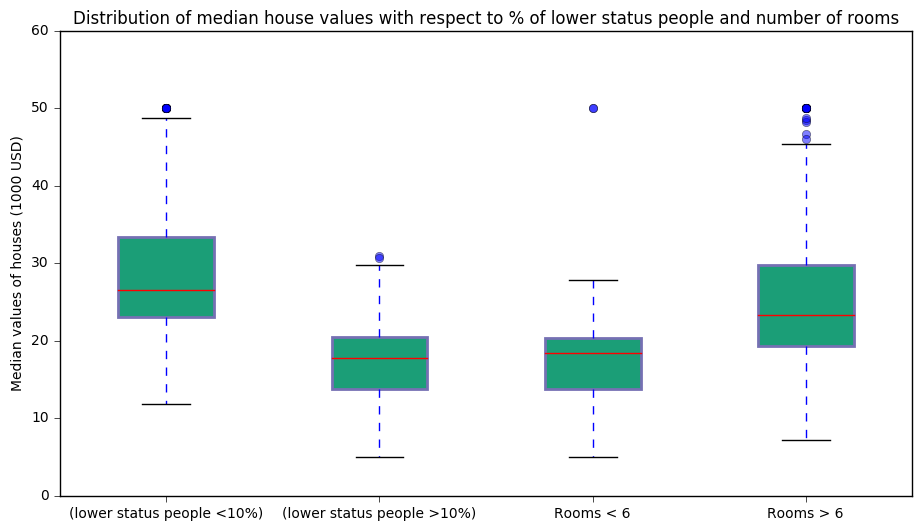

In [7]:
#seperating rows with lower and higher values of LSTAT
lowLstat= boston_df[boston_df['LSTAT']< 10.0]['MEDV']
highLstat= boston_df[boston_df['LSTAT']>= 10.0]['MEDV']
#seperating rows with lower and higher values of RM
lessRM= boston_df[boston_df['RM']< 6.0]['MEDV']
moreRM= boston_df[boston_df['RM']>= 6.0]['MEDV']
#merging the data
data=[lowLstat.tolist(),highLstat.tolist(), lessRM.tolist(),moreRM.tolist()]
#plotting boxplots for the data
figure = plt.figure(1, figsize=(11, 6))
ax = figure.add_subplot(111)
p = plt.boxplot(data, patch_artist=True)
#setting fill and border color of boxes 
for box in p['boxes']:
    box.set( color='#7570b3', linewidth=2)
    # change fill color
    box.set( facecolor = '#1b9e77' )
#setting outliers' colors and size
for flier in p['fliers']:
    flier.set(marker='o', color='#e7298a', alpha=0.5)
#Setting axes labels
ax.set_xticklabels(['(lower status people <10%)', '(lower status people >10%)', 'Rooms < 6', 'Rooms > 6'])
ax.set_ylabel('Median values of houses (1000 USD)')
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both', direction='out')
plt.ylim(0,60)
plt.title('Distribution of median house values with respect to % of lower status people and number of rooms')
plt.show()

The graph above shows clear relationships between the values of percentage of lower status of people and median housing rates as well as the values of number of rooms and median housing rates. For lower status people percentage less than 10, the median of the distribution for MEDV lies at around 27 while the same for LSTAT greater than 10 is located at around 17. As medv are calculated in 1000$ this difference between the distribution is very significant and tells us that as percenatge of lower status people in the vicinity decreases, the median housing prices increases showing a negative correlation between the two.

The graph also shows the relationship between average number of rooms per dwelling and the median housing rates. As the values of rooms are increasing, the median values of housing is also increasing showing a positive correlation.

## Experimental Setup

In the next few sections we will design an experiment to predict the median home value for an instance in the data.


### 2.1: Root Mean Square Error Calculator
For ease of use we will create a function to calculate RMSE from actual data and predictions.

In [8]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Roote Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print compute_rmse((2,2,3),(0,2,6)
2.08
"""
def compute_rmse(predictions, yvalues):
    #applying formula= RMSE = sqrt(mean((y-yhat)^2)
    rmse = np.sqrt(np.mean((np.subtract(yvalues,predictions))**2))
    return rmse



### 2.2:  Splitting the data into training and testing datasets

We will randomly select 66% of the data and put this in a training dataset ("bdata_train"), and place the remaining 34% in a testing dataset ("bdata_test")


In [9]:
# setting the seed to make solution replicable again
np.random.seed(seed=13579)

# splitting data in ratio 66%:34% 
bdata_train, bdata_test = train_test_split(boston_df, test_size=0.34, random_state = 200)

#shape of test data
bdata_test.shape

(173, 14)

## Nearest Neighbors Algorithm


### 3.1: Finding Nearest Neighbors: Distance function
First we will create a distance metric to measure the distance between two instances.  Here we will use the L-Norm distance for this.

In [10]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    dist =0;
    for i in range(0,len(x1)):
        dist=dist + (x1[i]-x2[i])**L
    dist=(dist)**(1/L)
    return dist
#calculating euclidean distance
Euc_dist = distance((3,4),(6,8),2)
print('Computed Euclidean Distance:',Euc_dist)

Computed Euclidean Distance: 5.0


### 3.2 Basic Nearest Neighbor algorithm

Next we will implement a basic nearest neighbor algorithm from scratch.  Our model will use training data, test data and the variables to use in model creation (args).  

We will use the training data (bdata_train) to "fit" the model. Then we will write a function that predicts, for each instance in the testing data (bdata_test), the median home value using the nearest neighbor algorithm.  For this, we can simply compare the test instance to every instance in the training set, and return the MEDV value of the closest training instance. The function will take L as an input, where L is passed to the distance function.

We will then compute the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.

In [11]:
"""
Function
--------
getDistances

Given training set and test instance, compute the distance for 
each training instance and return sorted distances

Parameters
----------
train_set : dataframe
    Dataframe with values for different explanatory variables

test_instance : list/array
    Array of numerical values corresponding to one instance from the test dataset

L : int
    Value to be used in distance function

Returns
-------
distances : Series
    Sorted distances in ascending order

"""
def getDistances(train_set, testInstance, L):
    #calculating distance for each training instance
    distances = train_set.apply(lambda row: distance(row,testInstance,L),axis=1)
    #sorting distances
    distances = distances.sort_values()
    return distances



In [12]:
"""
Function
--------
nneighbor

Given training set and test sets and list of explanatory variables to use, predict the values of MEDV
using nearest neighbor algorithm and compute the RMSE for all predictions

Parameters
----------
train : dataframe
    Dataframe with training values

test : dataframe
    Dataframe with test values

args : List
    List of explanatory variables to be used in fitting the model

L : int
    Value to be used in distance function

Returns
-------
rmse : int
    Computed Root Mean Square error for the predictions
"""
import time
def nneighbor(train, test, args, L):
    predictions =[]
    #seperating dependent variable
    train_medv=train['MEDV']
    test_medv=test['MEDV']
    #selecting only explanatory variables given as arguments
    train=train.loc[:,args]
    test=test.loc[:,args]
    for i in range(0,len(test)):
        x1=test.iloc[i].values
        #finding distance of test instance from each training set instance
        distances = getDistances(train, x1,L)
        predictions.append(train_medv.ix[distances.index[0]])
    #computing rmse for predictions and actual test medv values
    rmse=compute_rmse(predictions, test_medv)
    return rmse

We will now test our algorithm on the boston data using two features : Crime Rate and Number of Rooms.

In [13]:
#calculating rmse
rmse = nneighbor(bdata_train, bdata_test,['CRIM','RM'],2)
print("Calculated RSME by simple nearest neighbour algorithm=", rmse)

Calculated RSME by simple nearest neighbour algorithm= 7.82374110356


### 3.3 Normalization

We know that with Nearest Neighbor algorithms, we have to normalize the data to remove over representation of some features.  Hence, we will write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Then we will re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.


In [14]:
"""
Function
--------
normalize

Given an array normalize all its values by substracting mean and dividing by standard deviation

Parameters
----------
raw_data : array
    Array of numerical values to be normalized
    
Returns
-------
normalized_data : array
    Normalized array of numeric values

"""
def normalize(raw_data):
    #calculate mean of array
    mean = np.mean(raw_data)
    #calculate standard deviation
    std = np.std(raw_data)
    normalized_data=[]
    #normalize all datapoints
    for i in raw_data:
        normalized_data.append(((i-mean)/(std)))
    return normalized_data


"""
Function
--------
normalize_df

Given a dataframe with different numeric columns normalize all columns except MEDV
 by substracting mean and dividing by standard deviation

Parameters
----------
df : dataframe
    Dataframe with numeric columns
    
Returns
-------
df : dataframe
    Normalized dataframe 

"""
def normalize_df(df):
    for column in df:
        #normalize all columns except MEDV
        if (column !="MEDV"):
            df[column]=normalize(df[column])
    return df

In [15]:
#take out only useful columns from train dataframe
bdata_train_normalize = bdata_train[['CRIM','RM','MEDV']].copy()
#normalize the train data
bdata_train_normalize = normalize_df(bdata_train_normalize)
#take out only useful columns from test dataframe
bdata_test_normalize = bdata_test[['CRIM','RM','MEDV']].copy()
#normalize the test data
bdata_test_normalize = normalize_df(bdata_test_normalize)
#first 5 observations of normalized test data
bdata_train_normalize.head()


,CRIM,RM,MEDV
153,-0.151351,-0.870959,19.4
121,-0.413270,-0.426736,20.3
235,-0.380642,-0.303257,24.0
489,-0.399185,-1.315182,7.0
127,-0.389631,-0.895053,16.2


In [16]:
#calculate RMSE for normalized data using CRIM and RM as explanatory variables and L=2
rmse_normalize = nneighbor(bdata_train_normalize, bdata_test_normalize,['CRIM','RM'],2)
print("RMSE after normalization of data=",rmse_normalize)

RMSE after normalization of data= 9.69317142396


The RMSE after normalization is greater than the previous value. The normalized RMSE is more towards the true value as it considers the relative values of explanatory variables and hence deviation of error due to larger variables is not there in normalized error.

### 3.4 Optimization
 We will now try to increase the performance of our nearest neighbor algorithm by adding more features and by using different values of L in the distance function.  

In [17]:
#copy the train data
train_norm = bdata_train.copy()
#normalizing the columns
train_norm = normalize_df(train_norm)

#copy the test data
test_norm = bdata_test.copy()
#normalizing the columns
test_norm = normalize_df(test_norm)


In [18]:
#crim, rm, tax, L=2
rmse2= nneighbor(train_norm, test_norm, ['LSTAT','TAX'],2)
print("RMSE for model with LSTAT and TAX and L =2: ", rmse2)

#crim, rm, tax, L=3
rmse3= nneighbor(train_norm, test_norm, ['CRIM','RM','TAX'],3)
print("RMSE for model with Crim, RM and TAX and L =3: ", rmse3)

#crim, rm,tax, indus, L=2
rmse4= nneighbor(train_norm, test_norm, ['CRIM','RM','TAX', 'LSTAT'],2)
print("RMSE for model with Crim, RM, TAX, LSTAT and L =2: ", rmse4)

#crim, rm,tax, lstat, L=2
rmse2= nneighbor(train_norm, test_norm, ['TAX','RM','LSTAT'],2)
print("RMSE for model with TAX, RM and LSTAT and L =2: ", rmse2)

RMSE for model with LSTAT and TAX and L =2:  6.84810424803
RMSE for model with Crim, RM and TAX and L =3:  8.76395666444
RMSE for model with Crim, RM, TAX, LSTAT and L =2:  5.66135872905
RMSE for model with TAX, RM and LSTAT and L =2:  5.58143081496


As seen from the observations above we find that the lowest RMSE is by using TAX, RM and LSTAT as features and  L as 2. This was expected as in section 1.3 we have seen the strong relationships between LSTAT and RM with MEDV. As we are increasing the features and value of L the time taken by the algorithm is also increasing. So we have to find a optimize solution that gives low error but is also time efficient. The last model with three features (Tax, RM, LSTAT) with L =2 is found to be most efficient and accurate among all others tested above.

### 3.5 Cross-Validation

To prevent overfitting, we will use cross-validation to find optimal values.  Here we will implement a simple k-fold cross-validation algorithm. 

Then we will use 10-fold cross-validation to report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features. 

In [25]:
"""
Function
--------
kfoldCV

Given data and algorithm perform k fold cross-validation and compute RMSE

Parameters
----------
data : dataframe
    Dataframe with complete set of data with explanatory and dependent variables

args : array/List
    list of features' names that are to be passed to model as explanatory variables

k : int
    number of folds in k fold CV

algo: function
    The algorithm/model to be used for computing k-fold CV
    
K: int
    value of nearest neighbors to be used when using K nearest neighbor algorithm

L : int
    value passed to distance fuction to calculated L-norm distance

Returns
-------
rmse : int
    Average Root Mean Squared Error of the prediction for all folds

"""

def kfoldCV(data, args, k, algo, K, L):
    start_time = time.time()
    #randomly shuffle the data for random sampling
    df = data.sample(frac=1, random_state=200)
    #split the data into k equal parts
    split_data=np.array_split(df,k)
    rmse_all=[]
    #shortform for quick processing
    append = rmse_all.append
    for i in range(0,k):
        #take one part as test
        test_df=split_data[i]
        #use remaining parts as training
        indx = df.index.isin(split_data[i].index)
        train_df= df[~indx]
        #apply appropriate algorithm
        if (algo==nneighbor):
            rmse = algo(train_df,test_df,args,L)
        elif (algo==knn):
            rmse = algo(train_df,test_df,args,L,K)
        #append rmse for this fold
        append(rmse)
    #print ("Time taken for running all folds: " + str(round(time.time() - start_time,2)) + " seconds")
    #return mean of rmse for all folds
    return np.mean(rmse_all)

In [20]:
#computing average rmse using 10 fold cross validation on nneighbor algorithm with L=2
rmse_cv = kfoldCV(boston_df, ['CRIM','RM'],10,nneighbor,0,2)
print('Calculated average RMSE by k-fold CV: ', rmse_cv)


Time taken for running all folds: 22.31 seconds
Calculated average RMSE by k-fold CV:  6.640171804


### 3.6 K-Nearest Neighbors Algorithm

Now we are ready to implement the K-Nearest Neighbors algorithm.  Then using 10-fold cross validation, we will find the RMSE for K=3.

In [21]:
import operator
"""
Function
--------
findKNeighbors

Given train dataset and test instance, calculate distance 
and find the nearest K instances and return the MEDV values for these nearest neighbors

Parameters
----------
train_data : dataframe
    dataframe with train data with only the explanatory variables and MEDV present

test_record : array
    Array of numerical values for one instance of test data

L : int
    Value to be passed to distance function to compute L-norm distance

K : int
    value for number of nearest neighbors to be returned

Returns
-------
neighbors : Series
   Series with MEDV values of K nearest neighbors of test instance

"""
def findKNeighbors(train_data, test_record, L, K):
    #take out the dependent variable from train data
    train_medv=train_data['MEDV']
    train_data= train_data.drop('MEDV', axis=1)
    #calculate distance for each instance of train data
    distances = train_data.apply(lambda row: distance(row,test_record,L),axis=1)
    #sort the distances in ascending order
    distances = distances.sort_values()
    #take MEDV values for the first K distnaces
    neighbors = train_medv[distances.index[0:K]]
    return neighbors


In [22]:
"""
Function
--------
knn

Given train dataset and test dataset, predict the values of MEDV for
test data using k nearest neighbor and calculate RMSE

Parameters
----------
train : dataframe
    dataframe with train data with all features present

test : dataframe
    dataframe with test data with all features present
    
args : List
    List with names of explanatory variables/features to be used in model

L : int
    Value to be passed to distance function to compute L-norm distance

K : int
    value for number of nearest neighbors to be used

Returns
-------
rmse : float
   Root mean square error for the predictions

"""
def knn(train,test,args, L, K):
    #take out dependent variable
    test_medv = test['MEDV']
    #keeping only features passed as argument
    train_data=train.loc[:,args]
    train_data['MEDV']= train['MEDV']
    test=test.loc[:,args]
    predictions=[]
    append = predictions.append
    for i in range(len(test)):
        x1 =test.iloc[i].values
        #find MEDV values for K nearest neighbors 
        neighbors=findKNeighbors(train_data,x1,L,K)
        #predict test MEDV by taking mean of neighbor values
        append(np.mean(neighbors))
    #compute RMSE for all predictions
    rmse = compute_rmse(predictions,test_medv)
    return rmse


In [23]:
#compute rmse using 10-fold CV using knn algorithm with CRIM and RM features
#take K=3 and L=2
rmse_cv = kfoldCV(boston_df,['CRIM','RM'], 10,knn,3,2)
print('RMSE for 10-fold CV using k nearest neighbor with K=3: ', rmse_cv)

Time taken for running all folds: 23.4 seconds
RMSE for 10-fold CV using k nearest neighbor with K=3:  5.72148790993


### 3.7 Using cross validation to find K

What is the best choice of K?  To find this we will compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  We will use the following features in the model, after normalization: CRIM, ZN, RM, AGE, DIS, TAX.  

In [26]:
#normalizing the data
boston_df_norm = normalize_df(boston_df.copy())
rmse_all =[]
append = rmse_all.append
#values of K from 1 to 25
K=list(range(1,26))
#features to be used for model
args = ['CRIM','ZN','RM','AGE','DIS','TAX']
#run 10 fold CV for all values of K
for i in range(1,26):
    append(kfoldCV(boston_df_norm, args, 10, knn, i, 2))




In [27]:
#best value of K where rmse is minimum
K[rmse_all.index(min(rmse_all))]


4

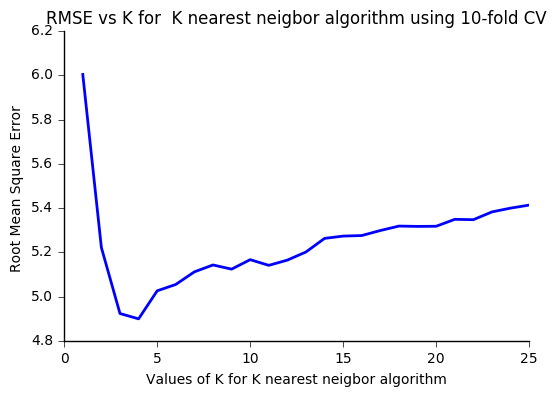

In [28]:
#plotting K and rmse
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(K,rmse_all, linewidth=2.0)
#remove top and right axes
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.tick_params(axis='both', direction='out')
# remove unneeded ticks 
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()
#setting axes labels and plot title
plt.xlabel('Values of K for K nearest neigbor algorithm')
plt.ylabel('Root Mean Square Error ')
plt.title('RMSE vs K for  K nearest neigbor algorithm using 10-fold CV')
plt.show()



The above figure and observations tells us that the most optimum value of K for K-nearest neighbor algorithm with 10-fold CV and using 'CRIM','ZN','RM','AGE','DIS','TAX' as features is 4. According to the figure the RMSE forst decreases while increasing K until it reaches its minimum value at K=4, after which it started increasing again almost linearly. So, for the current data and features, K=4 is the best value to be used.

*This project was done as a part of Data Science Specialization at University of Washington Information School*